<a href="https://colab.research.google.com/github/critclconsume/Sentiment-review-analysis/blob/main/reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sentimental Analysis**

Jadi ini model for prediksi sentimen dari hasil review like:  
this product is amazing = review positif   
this product is good but nothing special = review netral   
this product is terribe  = review negatif

first ini load data. Data set ada 2, Reviews.csv and yelp.csv


In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#nltk resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

#amazon
try:
    amazon_data = pd.read_csv('Reviews.csv')
    amazon_data = amazon_data[['Text', 'Score']].rename(columns={
        'Text': 'review', 'Score': 'stars'})
    amazon_data = amazon_data.dropna()
    print(f"Loaded {len(amazon_data)} Amazon reviews")
except FileNotFoundError:
    print("Error: amazon reviews not found.")
    exit()


#yelp
try:
    yelp_data = pd.read_csv('Reviews2.csv')
    yelp_data = yelp_data[['Score', 'Text']].rename(columns={'Text':'review'}) # Corrected 'Text' to 'text'
    yelp_data = yelp_data.dropna()
    yelp_data = yelp_data.sample(n=340000)
    print(f"Loaded {len(yelp_data)}Yelp reviews")
except FileNotFoundError:
    print("Error: yelp reviews not found")
    exit()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loaded 568454 Amazon reviews
Loaded 340000Yelp reviews


In [ ]:
#define sentimen funciton (in dataset theres a  star rating from 1 to 5)
def map_sentiment(stars):
  if stars <= 2:
    return 0 # or negative
  elif stars == 3:
    return 1 # or neutral
  else:
    return 2 # or positive

amazon_data['sentiment'] = amazon_data['stars'].apply(map_sentiment)
yelp_data['sentiment'] = yelp_data['Score'].apply(map_sentiment)

#preprocess text
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    # Get the list of English stopwords
    stop_words_list = stopwords.words('english') #review only in eng
    tokens = [t for t in tokens if t not in stop_words_list]
    return ' '.join(tokens)

#apply
amazon_data['review'] = amazon_data['review'].apply(preprocess_text)
yelp_data['review'] = yelp_data['review'].apply(preprocess_text)

#Combine datasets
data = pd.concat([amazon_data[['review', 'sentiment']], yelp_data[['review', 'sentiment']]], ignore_index=True)

#Balance classes
min_count = data['sentiment'].value_counts().min()
data = data.groupby('sentiment').sample(n=min_count, random_state=42)

#Print final dataset size
print(f"Combined dataset size: {len(data)} reviews")

#Save processed data
data.to_csv('processed_reviews.csv', index=False)
print("Processed dataset saved as 'processed_reviews.csv'")

#file combined as processed_reviwews.csv

Combined dataset size: 204456 reviews
Processed dataset saved as 'processed_reviews.csv'


In [ ]:
try:
    data = pd.read_csv('processed_reviews.csv')
    print(f"Loaded {len(data)} reviews")
except FileNotFoundError:
    print("Error: processed_reviews.csv not found. Please ensure it exists.")
    exit()
#just trynna check the combined data


Loaded 255840 reviews


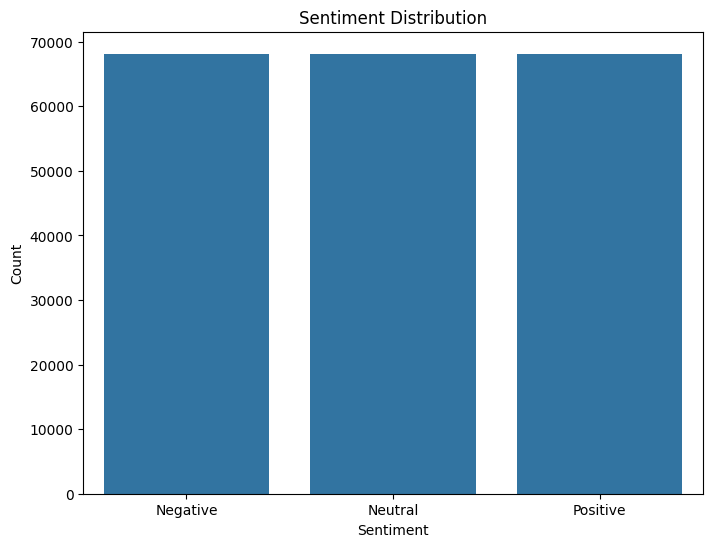

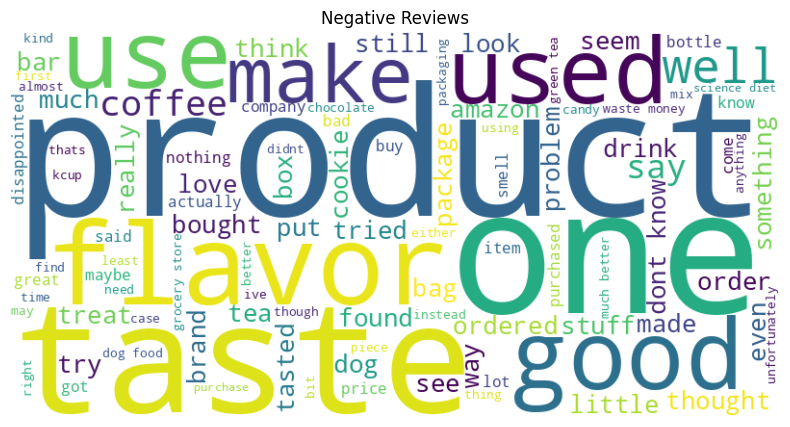

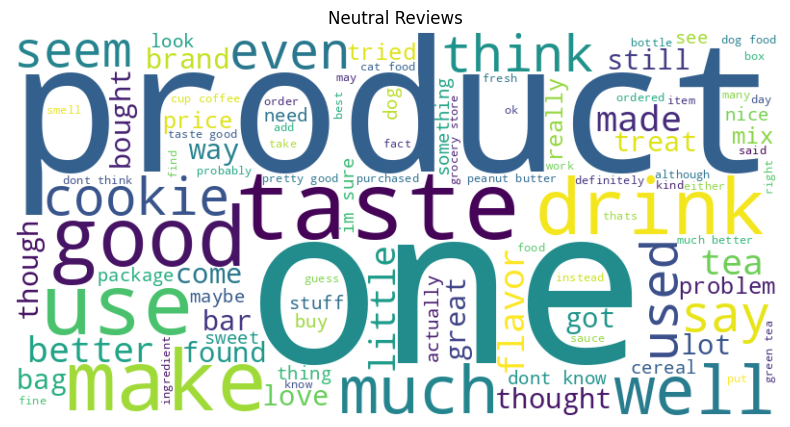

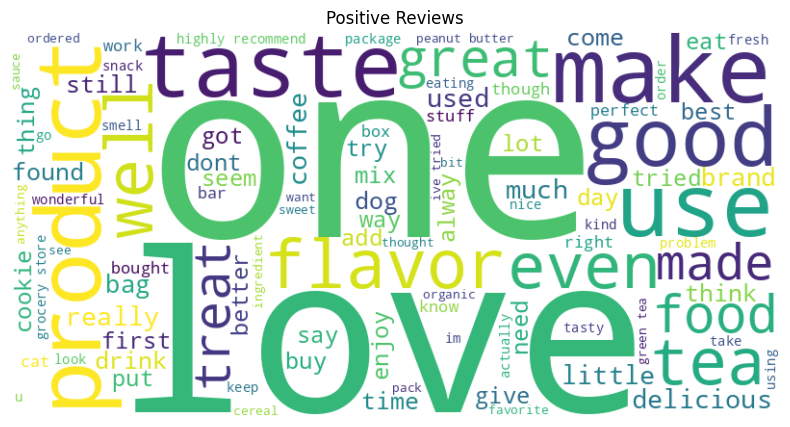

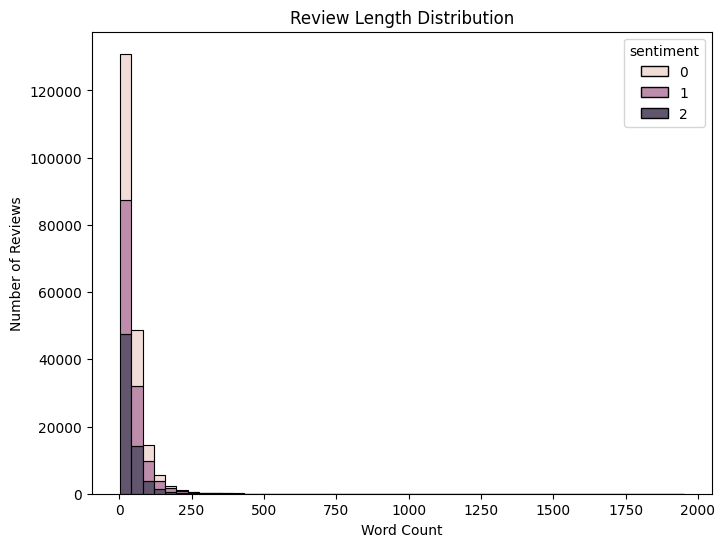

In [ ]:
#visualize.
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.savefig('sentiment_distribution.png')
plt.show()
plt.close()

# Word Clouds
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()
    plt.close()

for sentiment, label in [(0, 'Negative'), (1, 'Neutral'), (2, 'Positive')]:
    text = ' '.join(data[data['sentiment'] == sentiment]['review'])
    generate_wordcloud(text, f'{label} Reviews')

# Review Length Distribution
data['word_count'] = data['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='word_count', hue='sentiment', multiple='stack', bins=50)
plt.title('Review Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Number of Reviews')
plt.savefig('review_length_distribution.png')
plt.show()
plt.close()

In [ ]:
#finally...... now lets train
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier #cause its a multi classify (0,1,2)

# Prepare features and labels
X = data['review']
y = data['sentiment']

# Vectorize text using TF-IDF with n-grams
print("\nVectorizing text...")
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_vectorized = vectorizer.fit_transform(X)

# Split data into training and test sets (80, 20)
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42
)

# Train Random Forest model with class weights
print("Training model...")
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

#the train should probably take 1 hour or +. Depending on the sample


Vectorizing text...
Splitting data...
Training model...


RandomForestClassifier(class_weight='balanced', random_state=42)

Evaluating model...
Test Accuracy: 0.8641

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87     13543
     Neutral       0.87      0.86      0.86     13669
    Positive       0.86      0.87      0.86     13680

    accuracy                           0.86     40892
   macro avg       0.86      0.86      0.86     40892
weighted avg       0.86      0.86      0.86     40892



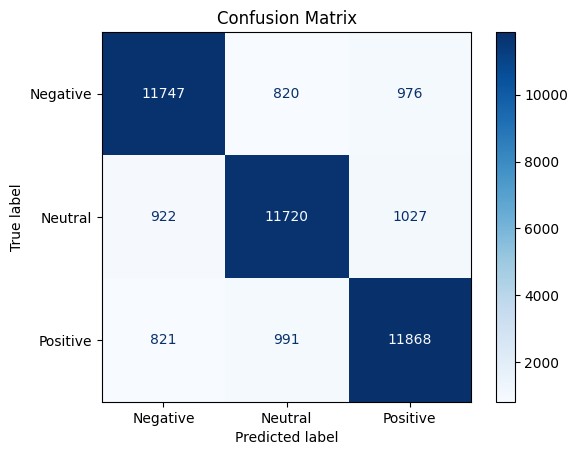

In [ ]:
#evaluate using confusion matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# Predict on test set
print("Evaluating model...")
y_pred = model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

#test accuracy should get up to 86%

In [ ]:
def predict_sentiment(review):
    # Preprocess the review using the existing preprocess_text function
    processed_review = preprocess_text(review)

    # Vectorize the processed review using the fitted vectorizer
    vectorized_review = vectorizer.transform([processed_review])

    # Predict the sentiment using the trained model
    prediction = model.predict(vectorized_review)[0]

    # Map the prediction to a sentiment label
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_label = sentiment_labels[prediction]

    return predicted_label

In [ ]:
#this last shell is the testing for the model

# Example reviews
examples = [
    "This restaurant was amazing! Great food and service!",
    "The product was okay, nothing special.",
    "Terrible experience, never going back!"
]

# Test example reviews
print("\nTesting example reviews:")
for review in examples:
    prediction = predict_sentiment(review)
    print(f"Review: {review}")
    print(f"Predicted: {prediction}\n")

# Interactive testing
print("Enter your own reviews (type 'quit' to stop):")
while True:
    review = input("Review: ")
    if review.lower() == 'quit':
        break
    if review.strip() == '':
        print("Please enter a valid review.\n")
        continue
    prediction = predict_sentiment(review)
    print(f"Predicted: {prediction}\n")

print("Testing complete.")


Testing example reviews:
Review: This restaurant was amazing! Great food and service!
Predicted: Positive

Review: The product was okay, nothing special.
Predicted: Neutral

Review: Terrible experience, never going back!
Predicted: Negative

Enter your own reviews (type 'quit' to stop):
Review: this product is soo good
Predicted: Positive

Review: this  product is terrible 
Predicted: Negative

Review: my nigga
Predicted: Positive

Review: this product is decent, nothing special
Predicted: Neutral



KeyboardInterrupt: Interrupted by user